In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.patches as mpatches
from city_sustainability.models import unet_model
from city_sustainability.quality import life_quality
from city_sustainability.preprocessing import image_resize
from city_sustainability.loading_data import loading_paths
from matplotlib.colors import ListedColormap, BoundaryNorm
from city_sustainability.models.unet_model import compute_iou
from city_sustainability.loading_data import image_and_label_arrays

2023-05-30 11:51:28.234944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 11:51:28.525496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 11:51:28.526736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 11:51:29.475911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [42]:
def split_data (data_path, split_files_directory):
    
    # Retrieve image_paths, label_paths
    X_paths, y_paths = loading_paths(data_path)
    
    # Load the paths from the text files
    with open(split_files_path + 'train.txt', 'r') as file:
        train_list = [line.strip() for line in file.readlines()]
    
    with open(split_files_path + 'val.txt', 'r') as file:
        val_list = [line.strip() for line in file.readlines()]

    with open(split_files_path + 'test.txt', 'r') as file:
        test_list = [line.strip() for line in file.readlines()]    
    
    (X_train_paths,  
     y_train_paths,
     X_val_paths,
     y_val_paths,
     X_test_paths,
     y_test_paths) = ([], [], [], [], [], [])
    
    for i in range(len(X_paths)):
        X_path = X_paths[i]
        y_path = y_paths[i]
        file_name = X_path.split('/')[-1] 
        if file_name in train_list:
            X_train_paths.append(X_path)
            y_train_paths.append(y_path)
        if file_name in val_list:
            X_val_paths.append(X_path)
            y_val_paths.append(y_path)
        if file_name in test_list:
            X_test_paths.append(X_path)
            y_test_paths.append(y_path)
    return (X_train_paths,  
            y_train_paths,
            X_val_paths,
            y_val_paths,
            X_test_paths,
            y_test_paths)

In [43]:
# Paths for input data and directory containing the train.txt, test.txt, and val.txt files
data_path = '../../raw_data/OpenEarthMap_wo_xBD'
split_files_path = '../../raw_data/OpenEarthMap_wo_xBD/'

(X_train_paths, 
 y_train_paths, 
 X_val_paths, 
 y_val_paths, 
 X_test_paths, 
 y_test_paths) = split_data (data_path, split_files_directory)

In [44]:
print('X_paths =', len(X_paths))
print('y_paths =', len(y_paths))
print('X_train_paths =', len(X_train_paths))
print('y_train_paths =', len(y_train_paths))
print('X_test_paths =', len(X_test_paths))
print('y_test_paths =', len(y_test_paths))
print('X_val_paths =', len(X_val_paths))
print('y_val_paths =', len(y_val_paths))

X_paths = 2687
y_paths = 2687
X_train_paths = 2303
y_train_paths = 2303
X_test_paths = 0
y_test_paths = 0
X_val_paths = 384
y_val_paths = 384


In [34]:
# Import all image array as X and label array as y
X_train, y_train = image_and_label_arrays(X_train_paths, y_train_paths, sampling_ratio=1.0)
X_test, y_test = image_and_label_arrays(X_test_paths, y_test_paths, sampling_ratio=1.0)
X_val, y_val = image_and_label_arrays(X_val_paths, y_val_paths, sampling_ratio=1.0)

In [35]:
print('X_train =', len(X_train_paths))
print('y_train =', len(y_train_paths))
print('X_test=', len(X_test_paths))
print('y_test =', len(y_test_paths))
print('X_val =', len(X_val_paths))
print('y_val =', len(y_val_paths))

X_train = 2303
y_train = 2303
X_test= 0
y_test = 0
X_val = 384
y_val = 384


In [51]:
y_val.shape

(384, 256, 256, 9)

In [36]:
# Scale X and y
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

In [37]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(X_val_scaled.shape)

(2303, 256, 256, 3)
(0,)
(384, 256, 256, 3)


In [38]:
path = '../../model_training/mallik/model_2703.h5'
model = load_model(path, custom_objects={'compute_iou': compute_iou})

2023-05-30 13:53:39.451981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-30 13:53:39.453640: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [39]:
y_pred = model.predict(X_val)

12/12 [==============================] - 58s 5s/step


In [45]:
y_pred.shape

(384, 256, 256, 9)

In [49]:
# Create a DataFrame from your color dictionary
df = pd.DataFrame(list(class_colors.items()), columns=['Class', 'Color'])
def color_cells(val):
    color = val 
    return 'background-color: %s' % color
class_color = df.style.applymap(color_cells, subset=['Color'])
class_color

,Class,Color
0,Other,#FFFF00
1,Bareland,#800000
2,Rangeland,#00FF24
3,Developed space,#949494
4,Road,#FFFFFF
5,Tree,#226126
6,Water,#0045FF
7,Agriculture land,#4BB549
8,Building,#DE1F07


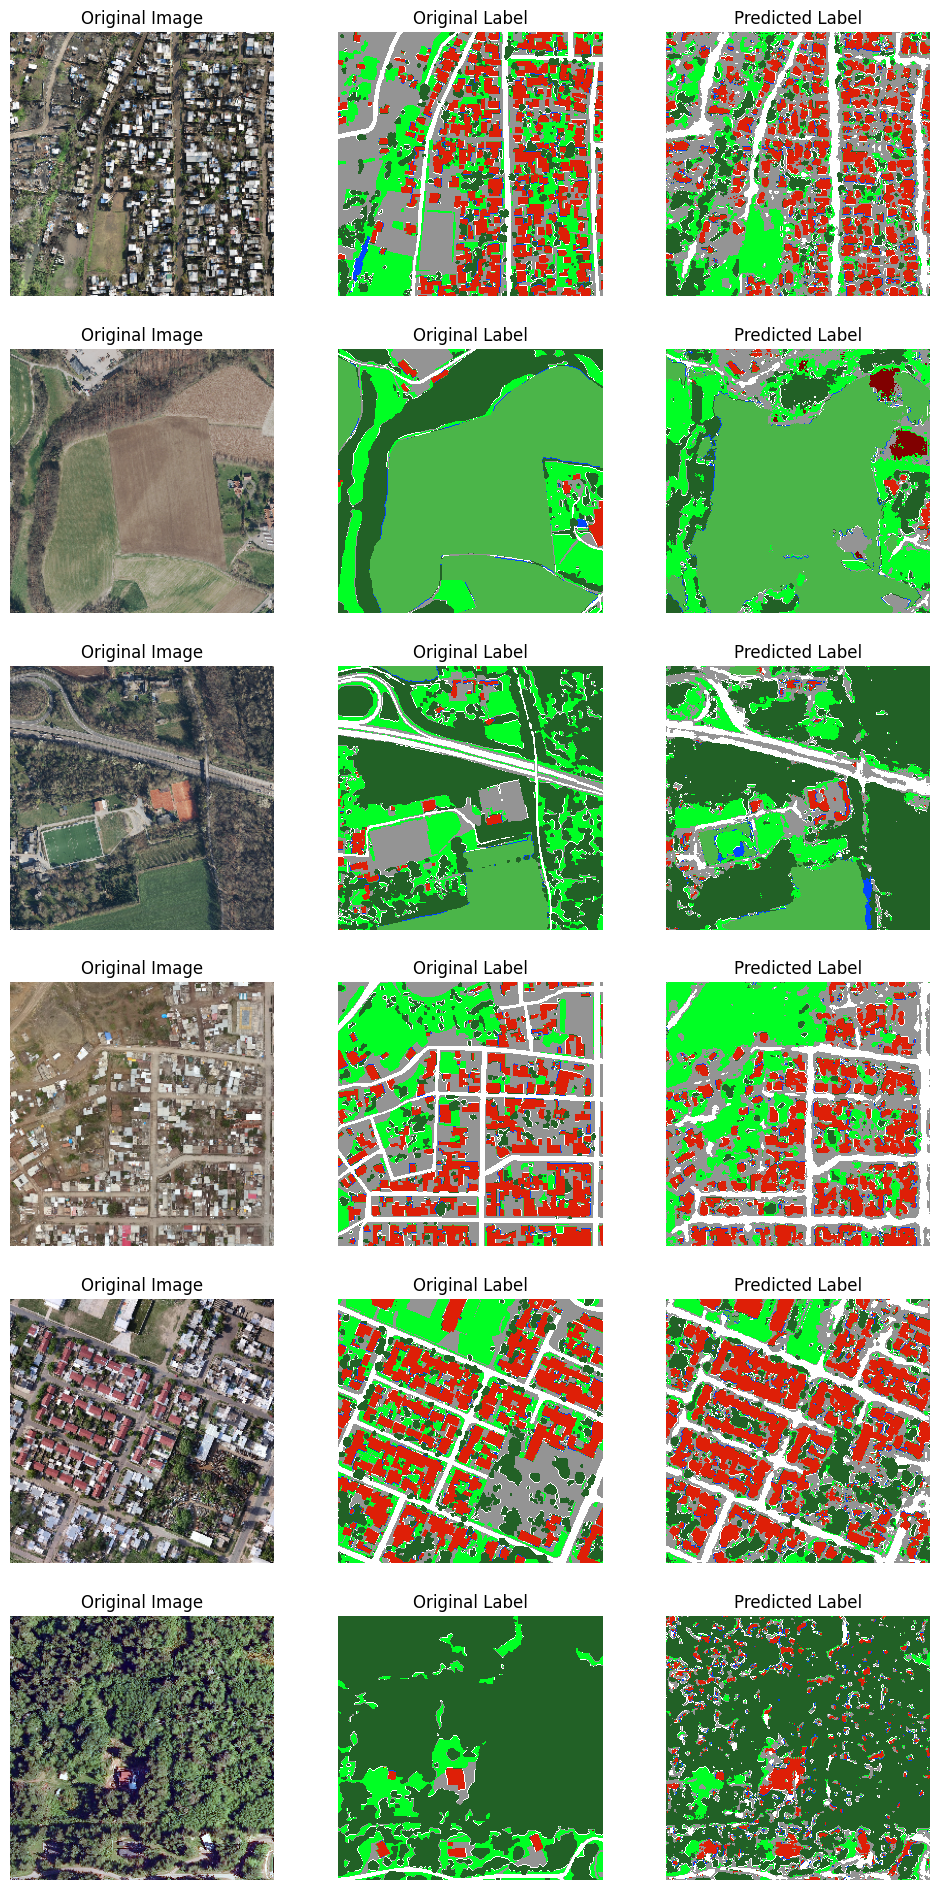

In [54]:
# Create Numpy
y_pred_np = np.argmax(y_pred, axis=-1)
y_val_np = np.argmax(y_val, axis=-1)

# Defining classes colors
class_colors = {
    "Other": '#FFFF00',
    "Bareland": '#800000',
    "Rangeland": '#00FF24',
    "Developed space": '#949494',
    "Road": '#FFFFFF',
    "Tree": '#226126',
    "Water": '#0045FF',
    "Agriculture land": '#4BB549',
    "Building": '#DE1F07'}

labels = list(range(len(class_colors))) 
colors = list(class_colors.values())     
cmap = ListedColormap(colors)
norm = BoundaryNorm(labels, cmap.N)

# Create the figure and subplots
num_images = 6 
fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

# Iterate through the image sets
for i in range(num_images):
    index = i * 10  
    if index >= len(X_val):
        break
    # Display the original image
    axs[i, 0].imshow(X_val[index])
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')
    # Display the original label
    axs[i, 1].imshow(y_val_np[index], cmap=cmap, vmin=0, vmax=8)
    axs[i, 1].set_title('Original Label')
    axs[i, 1].axis('off')
    # Display the predicted label
    axs[i, 2].imshow(y_pred_np[index], cmap=cmap, vmin=0, vmax=8)
    axs[i, 2].set_title('Predicted Label')
    axs[i, 2].axis('off')

# Display the figure and adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()